In [2]:
%pip install wfdb
!git clone https://github.com/MIT-LCP/wfdb-python
%cd wfdb-python

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath

import wfdb
from wfdb import processing

Note: you may need to restart the kernel to use updated packages.
c:\Users\jitbh\OneDrive\Documents\GitHub\FinalYearProject---BP-from-ECG-PPG\wfdb-python


fatal: destination path 'wfdb-python' already exists and is not an empty directory.


In [27]:
# dbs = wfdb.get_dbs()
# display(dbs)

ecg = wfdb.rdheader('a19', pn_dir='challenge-2010/set-a/')

if "ECG I" in ecg.sig_name and "ABP" in ecg.sig_name:
    print("Yes")
else:
    print("No")

No


In [33]:

ecg1abp = []
ecg2abp = [] 
ecg12abp = []

for i in range(0,100):

    if i < 10:
        fileNames = "c0{}".format(i)
    else:
        fileNames = "c{}".format(i)

    ecg = wfdb.rdheader(fileNames, pn_dir='challenge-2010/set-c/')
    if "I" in ecg.sig_name and "ABP" in ecg.sig_name:
        if "II" in ecg.sig_name:
            ecg12abp.append(fileNames)
        else:
            ecg1abp.append(fileNames)
    if "II" in ecg.sig_name and "ABP" in ecg.sig_name:
        if "I" in ecg.sig_name:
            ecg12abp.append(fileNames)
        else:
            ecg2abp.append(fileNames)

ecg12abp = list( dict.fromkeys(ecg12abp) )

print("ECG1", ecg1abp)
print("ECG1 size:", len(ecg1abp))
print("ECG2", ecg2abp)
print("ECG2 size:", len(ecg2abp))
print("ECG12", ecg12abp)
print("ECG12 size:", len(ecg12abp))


ECG1 []
ECG1 size: 0
ECG2 ['c00', 'c03', 'c04', 'c05', 'c07', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c19', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c32', 'c33', 'c34', 'c35', 'c37', 'c38', 'c39', 'c40', 'c41', 'c42', 'c44', 'c45', 'c46', 'c47', 'c48', 'c49', 'c50', 'c52', 'c53', 'c54', 'c55', 'c56', 'c57', 'c58', 'c59', 'c60', 'c61', 'c63', 'c64', 'c65', 'c66', 'c67', 'c68', 'c71', 'c72', 'c73', 'c74', 'c75', 'c76', 'c77', 'c78', 'c79', 'c80', 'c82', 'c83', 'c87', 'c88', 'c90', 'c91', 'c92', 'c93', 'c95', 'c96', 'c97', 'c98', 'c99']
ECG2 size: 81
ECG12 ['c02', 'c06', 'c18', 'c30', 'c36', 'c43', 'c62', 'c84', 'c85', 'c94']
ECG12 size: 10


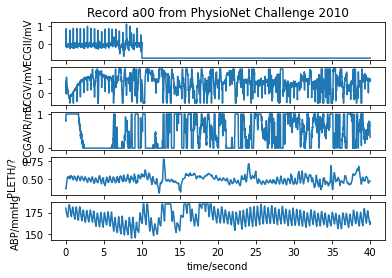

{'record_name': 'ecg-record',
 'n_sig': 5,
 'fs': 125,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 5000,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['ECGII', 'ECGV', 'ECGAVR', 'PLETH', 'ABP'],
 'p_signal': array([[-1.00971628e-01,  6.74876348e-01,  8.10173348e-01,
          3.68531080e-01,  1.80312584e+02],
        [-7.38718869e-02,  7.14249262e-01,  7.90591842e-01,
          3.66568985e-01,  1.79921604e+02],
        [-3.94021633e-02,  7.29052554e-01,  9.70643941e-01,
          3.66568985e-01,  1.79335134e+02],
        ...,
        [-7.58620690e-01,  8.59590681e-01,  4.50099699e-01,
          4.76052439e-01,  1.62321346e+02],
        [-7.58620690e-01,  8.44825838e-01,  3.74767416e-01,
          4.75075038e-01,  1.63298797e+02],
        [-7.58620690e-01,  8.49747453e-01,  3.19963638e-01,
          4.74097638e-01,  1.64472352e+02]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['ecg-record.dat',
  'ecg-record.dat',
 

In [5]:
# Read a WFDB record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data. Read the files hosted on PhysioNet https://physionet.org/content/challenge-2010/1.0.0/
str = 'a00'
# sig, fields = wfdb.rdsamp(str, channels=[0,1], pn_dir='challenge-2010/set-a/')
sig, fields = wfdb.rdsamp(str, sampfrom=70000, sampto=75000, channels=[1,2,3,4,5], pn_dir='challenge-2010/set-a/')
# Call the gateway wrsamp function, manually inserting fields as function input parameters
fmt = ['16', '16', '16', '16', '16']
units = ['mV', 'mV', 'mV', '?', 'mmHg']
names = ['ECGII', 'ECGV', 'ECGAVR', 'PLETH', 'ABP']
wfdb.wrsamp('ecg-record', fs=125, units=units, sig_name=names, p_signal=sig, fmt=fmt)
# The new file can be read
record = wfdb.rdrecord('ecg-record')
wfdb.plot_wfdb(record=record, plot_sym='true', title='Record ' +  str + ' from PhysioNet Challenge 2010', time_units='seconds') 
display(record.__dict__)
# Convert to seconds
# Snapshot for seconds

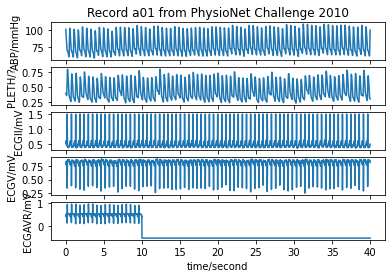

{'record_name': 'ecg-record',
 'n_sig': 5,
 'fs': 125,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 5000,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['ABP', 'PLETH', 'ECGII', 'ECGV', 'ECGAVR'],
 'p_signal': array([[100.71680406,   0.39883134,   0.51562576,   0.81567915,
           0.49409623],
        [ 99.15232478,   0.39785401,   0.5390712 ,   0.83136284,
           0.46470527],
        [ 97.39237885,   0.39687667,   0.57031439,   0.83528621,
           0.43529184],
        ...,
        [ 93.67627428,   0.30792171,   0.48438257,   0.83136284,
          -0.50196078],
        [ 97.00069949,   0.30596704,   0.48438257,   0.82548268,
          -0.50196078],
        [ 99.73872474,   0.3049897 ,   0.49024828,   0.82155931,
          -0.50196078]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['ecg-record.dat',
  'ecg-record.dat',
  'ecg-record.dat',
  'ecg-record.dat',
  'ecg-record.dat'],
 'fmt': ['16', '16', '16', '16

In [6]:
# Read a WFDB record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data. Read the files hosted on PhysioNet https://physionet.org/content/challenge-2010/1.0.0/
str = 'a01'
# sig, fields = wfdb.rdsamp(str, channels=[0,1], pn_dir='challenge-2010/set-a/')
sig, fields = wfdb.rdsamp(str, sampfrom=70000, sampto=75000, channels=[0,2,3,4,5], pn_dir='challenge-2010/set-a/')
# Call the gateway wrsamp function, manually inserting fields as function input parameters
fmt = ['16', '16', '16', '16', '16']
units = ['mmHg', '?', 'mV', 'mV', 'mV' ]
names = ['ABP', 'PLETH', 'ECGII', 'ECGV', 'ECGAVR']
wfdb.wrsamp('ecg-record', fs=125, units=units, sig_name=names, p_signal=sig, fmt=fmt)
# The new file can be read
record = wfdb.rdrecord('ecg-record')
wfdb.plot_wfdb(record=record, plot_sym='true', title='Record ' +  str + ' from PhysioNet Challenge 2010', time_units='seconds') 
display(record.__dict__)

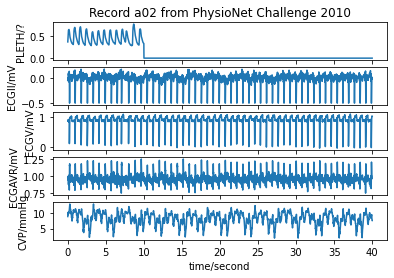

{'record_name': 'ecg-record',
 'n_sig': 5,
 'fs': 125,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 5000,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['PLETH', 'ECGII', 'ECGV', 'ECGAVR', 'CVP'],
 'p_signal': array([[ 3.73418128e-01, -3.51656301e-02,  8.74989459e-01,
          9.86276241e-01,  8.87872342e+00],
        [ 4.02726935e-01, -2.93011948e-02,  8.59368976e-01,
          9.92158832e-01,  9.30889705e+00],
        [ 4.36940481e-01, -4.49222041e-02,  8.65222328e-01,
          1.00196315e+00,  9.81745118e+00],
        ...,
        [ 0.00000000e+00, -9.76706493e-03,  1.01366886e+00,
          1.00196315e+00,  7.58786831e+00],
        [ 0.00000000e+00, -3.91312054e-03,  1.01952221e+00,
          9.96080560e-01,  7.58786831e+00],
        [ 0.00000000e+00,  1.95236389e-02,  1.01366886e+00,
          9.70589330e-01,  7.58786831e+00]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['ecg-record.dat',
  'ecg-record.dat',
 

In [7]:
str = 'a02'
# sig, fields = wfdb.rdsamp(str, channels=[0,1], pn_dir='challenge-2010/set-a/')
sig, fields = wfdb.rdsamp(str, sampfrom=70000, sampto=75000, channels=[1,2,3,4,5], pn_dir='challenge-2010/set-a/')
# Call the gateway wrsamp function, manually inserting fields as function input parameters
fmt = ['16', '16', '16', '16', '16']
units = ['?', 'mV', 'mV', 'mV', 'mmHg']
names = ['PLETH', 'ECGII', 'ECGV', 'ECGAVR', 'CVP']
wfdb.wrsamp('ecg-record', fs=125, units=units, sig_name=names, p_signal=sig, fmt=fmt)
# The new file can be read
record = wfdb.rdrecord('ecg-record')
wfdb.plot_wfdb(record=record, plot_sym='true', title='Record ' +  str + ' from PhysioNet Challenge 2010', time_units='seconds') 
display(record.__dict__)
# Convert to seconds
# Snapshot for seconds


# go through all 100 training in Set A, note down what signals they come with. ECGII and ABP


# ECGV is redundant

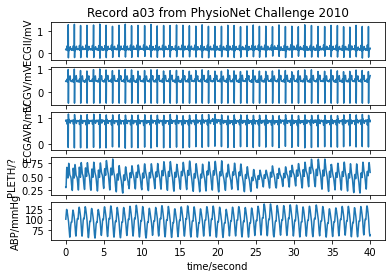

{'record_name': 'ecg-record',
 'n_sig': 5,
 'fs': 125,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 5000,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['ECGII', 'ECGV', 'ECGAVR', 'PLETH', 'ABP'],
 'p_signal': array([[  0.15626634,   0.4492081 ,   0.91175637,   0.30303806,
         100.91257006],
        [  0.15040485,   0.45506695,   0.90588235,   0.29912101,
         102.86807525],
        [  0.16015798,   0.46483923,   0.89018488,   0.29717218,
         105.21468148],
        ...,
        [  0.2011884 ,   0.67578019,   0.90195297,   0.59921159,
          61.80003704],
        [  0.22461034,   0.69530212,   0.86077468,   0.59041762,
          62.77778963],
        [  0.21094154,   0.69921556,   0.88038148,   0.58161395,
          63.95109275]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['ecg-record.dat',
  'ecg-record.dat',
  'ecg-record.dat',
  'ecg-record.dat',
  'ecg-record.dat'],
 'fmt': ['16', '16', '16', '16

In [8]:
str = 'a03'
# sig, fields = wfdb.rdsamp(str, channels=[0,1], pn_dir='challenge-2010/set-a/')
sig, fields = wfdb.rdsamp(str, sampfrom=70000, sampto=75000, channels=[1,2,3,4,5], pn_dir='challenge-2010/set-a/')
# Call the gateway wrsamp function, manually inserting fields as function input parameters
fmt = ['16', '16', '16', '16', '16']
units = ['mV', 'mV', 'mV', '?', 'mmHg']
names = ['ECGII', 'ECGV', 'ECGAVR', 'PLETH', 'ABP']
wfdb.wrsamp('ecg-record', fs=125, units=units, sig_name=names, p_signal=sig, fmt=fmt)
# The new file can be read
record = wfdb.rdrecord('ecg-record')
wfdb.plot_wfdb(record=record, plot_sym='true', title='Record ' +  str + ' from PhysioNet Challenge 2010', time_units='seconds') 
display(record.__dict__)
# Convert to seconds
# Snapshot for seconds

In [9]:
record = wfdb.rdheader('a10', pn_dir='challenge-2010/set-a/')
display(record.__dict__)

{'record_name': 'a10',
 'n_sig': 6,
 'fs': 125,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 75000,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['RESP', 'PLETH', 'ECG II', 'ECG V', 'ECG AVR', 'ABP'],
 'p_signal': None,
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['a10.dat',
  'a10.dat',
  'a10.dat',
  'a10.dat',
  'a10.dat',
  'a10.dat'],
 'fmt': ['16', '16', '16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1, 1, 1],
 'skew': [None, None, None, None, None, None],
 'byte_offset': [None, None, None, None, None, None],
 'adc_gain': [409.0, 1023.0, 512.0, 512.0, 510.0, 5.11333],
 'baseline': [307, 0, 255, 255, 256, 76],
 'units': ['pm', '?', 'mV', 'mV', 'mV', 'mmHg'],
 'adc_res': [10, 10, 10, 10, 10, 10],
 'adc_zero': [512, 512, 512, 512, 512, 512],
 'init_value': [248, 350, 457, 636, 524, 591],
 'checksum': [24086, 14948, 1622, 30733, 10128, -27414],
 'block_size': [0, 0, 0, 0, 0, 0]}

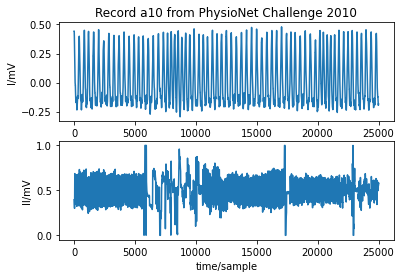

{'record_name': 'ecg-record',
 'n_sig': 2,
 'fs': 250,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 25000,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['I', 'II'],
 'p_signal': array([[ 0.44253827,  0.39590136],
        [ 0.44253827,  0.39394818],
        [ 0.44253827,  0.3910184 ],
        ...,
        [-0.1858175 ,  0.57770013],
        [-0.18336524,  0.57184057],
        [-0.18336524,  0.56205939]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['ecg-record.dat', 'ecg-record.dat'],
 'fmt': ['16', '16'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [84819.78333333333, 65534.0],
 'baseline': [-7881, -32767],
 'units': ['mV', 'mV'],
 'adc_res': [16, 16],
 'adc_zero': [0, 0],
 'init_value': [29655, -6822],
 'checksum': [11804, 20438],
 'block_size': [0, 0]}

In [10]:
# Write a WFDB record without using a Record object via the gateway wrsamp function.
# This is the basic way to write physical signals to a WFDB file. 

# Read part of a record from Physionet
sig, fields = wfdb.rdsamp('a10', sampfrom=50000, channels=[0,1], pn_dir='challenge-2010/set-a/')

# Call the gateway wrsamp function, manually inserting fields as function input parameters
wfdb.wrsamp('ecg-record', fs=250, units=['mV', 'mV'], sig_name=['I', 'II'], p_signal=sig, fmt=['16', '16'])

# The new file can be read
record = wfdb.rdrecord('ecg-record')
wfdb.plot_wfdb(record=record, title='Record a10 from PhysioNet Challenge 2010') 
display(record.__dict__)

# ECG processing

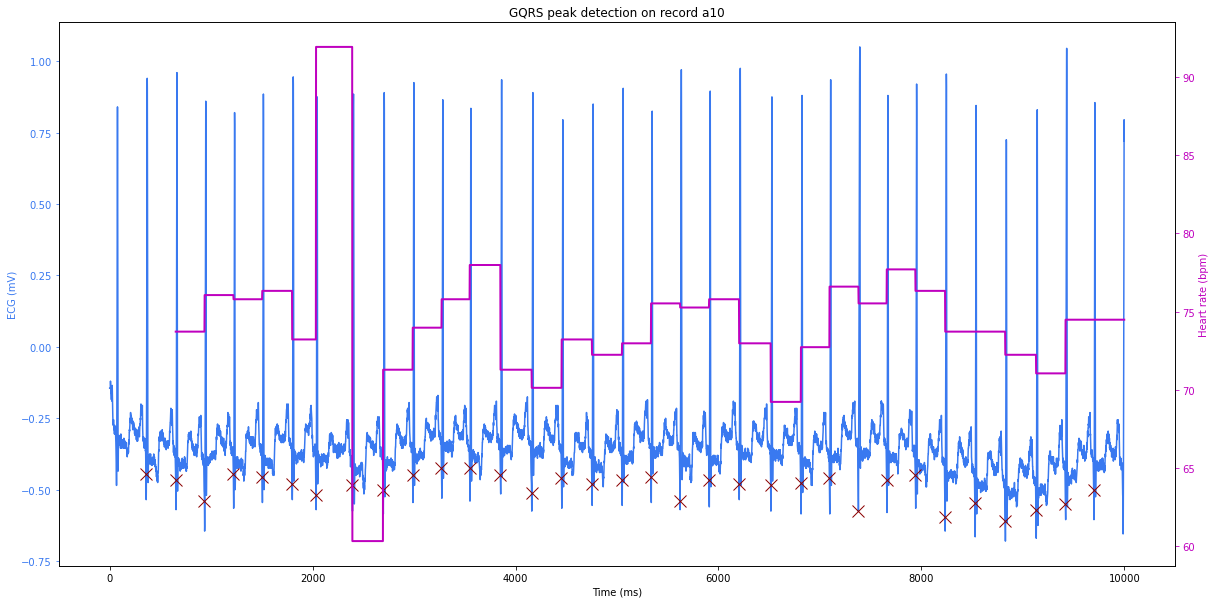

Corrected GQRS detected peak indices: [370, 663, 947, 1231, 1515, 1809, 2045, 2403, 2706, 2998, 3283, 3560, 3863, 4171, 4466, 4765, 5061, 5347, 5634, 5919, 6215, 6527, 6824, 7106, 7393, 7670, 7953, 8246, 8539, 8837, 9142, 9432, 9710]


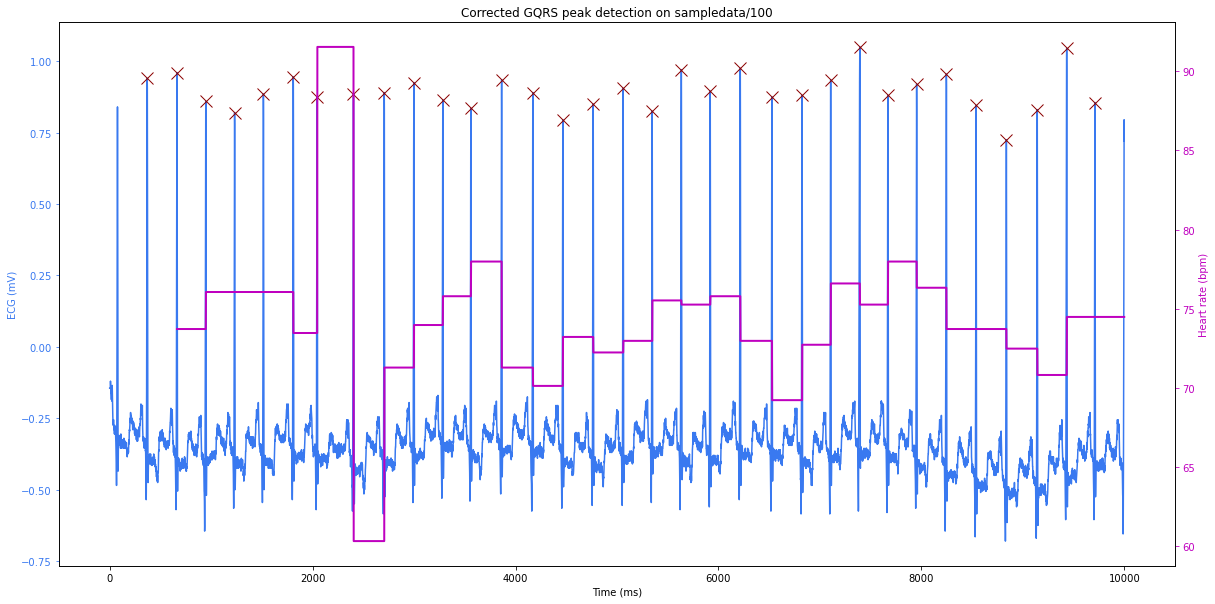

In [11]:
# Demo 19 - Use the GQRS detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

# Load the WFDB record and the physical samples
record = wfdb.rdrecord('a10', pn_dir='challenge-2010/set-a/', sampfrom=0, sampto=10000, channels=[0])

record = wfdb.rdrecord('sample-data/100', sampfrom=0, sampto=10000, channels=[0])


# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="GQRS peak detection on record a10")
    
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Display results
print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on sampledata/100")